In [1]:
!pip install -q evaluate transformers==4.28.1
!pip install -U -q datasets
!pip install -q torchaudio==0.12
!add-apt-repository -y ppa:savoury1/ffmpeg4
!apt-get -qq install -y ffmpeg
!pip install -q mlflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 23.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 39.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 493.7/493.7 kB 50.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 37.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.3/776.3 MB 1.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchdata 0.7.0 requires torch==2.1.0, but you have torch 1.12.0 which is incompatible.
torcht

In [2]:
#imports
import pandas as pd
import gc
import re
import numpy as np
import torch
from imblearn.over_sampling import RandomOverSampler
import datasets
import transformers
print(transformers.__version__)

import warnings
warnings.filterwarnings("ignore")

from tqdm import tqdm
tqdm.pandas()

4.28.1


In [3]:
RATE_HZ = 16000 # resampling rate in Hz
MAX_LENGTH = 480000 # maximum audio interval length to consider (= RATE_HZ * SECONDS)
labels = ['disco', 'metal', 'reggae', 'blues', 'rock', 'classical', 'jazz', 'hiphop', 'country', 'pop']
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label

print(id2label, '\n\n', label2id)

{0: 'disco', 1: 'metal', 2: 'reggae', 3: 'blues', 4: 'rock', 5: 'classical', 6: 'jazz', 7: 'hiphop', 8: 'country', 9: 'pop'} 

 {'disco': 0, 'metal': 1, 'reggae': 2, 'blues': 3, 'rock': 4, 'classical': 5, 'jazz': 6, 'hiphop': 7, 'country': 8, 'pop': 9}


In [4]:
from pathlib import Path
import torchaudio

def load_data():
    file_list = []
    label_list = []
    for file in Path('/kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original/').glob('*/*.wav'):
        if not 'jazz.00054' in str(file): # skip bad example
            genre = re.match(r"(\D+)", file.stem).group(1).rstrip('.')
            file_list.append(file)
            label_list.append(label2id[genre])
    dd = pd.DataFrame()
    dd['file'] = file_list
    dd['label'] = label_list
    return dd

In [5]:
%%time
dd = load_data()
dd.head()

CPU times: user 4.01 ms, sys: 161 µs, total: 4.17 ms
Wall time: 21.4 ms


,file,label


In [7]:
!pip install librosa spleeter


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.3/77.3 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.8/511.8 MB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 58.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 57.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 76.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.7/438.7 kB 36.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.8/82.8 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.9/54.9 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [1]:
import librosa
from spleeter.separator import Separator

# Load the audio file
audio_file = "/content/Namaami Namaami  Kabzaa  Kannada  semiclassical dance  Nivi and Ishanvi  Laasya.mp3"
y, sr = librosa.load(audio_file, sr=None)

# Use Spleeter to separate vocals and accompaniment
separator = Separator("spleeter:4stems")
output = separator.separate(y)

# Save the accompaniment (instrumental) audio
accompaniment_audio = output['accompaniment']
librosa.output.write_wav("instrumental_audio.wav", accompaniment_audio, sr=sr)

# You can also save the vocals if needed
# vocals_audio = output['vocals']
# librosa.output.write_wav("vocals_audio.wav", vocals_audio, sr=sr)


IndexError: ignored

In [2]:
!pip install spotipy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.3/250.3 kB 7.4 MB/s eta 0:00:00


In [3]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from collections import defaultdict

sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id="a04d200ec4f34289948bc2f912c97cf2",
                                                           client_secret="9a17de9318a4477da09c5f231d5436fa"))

def find_song(name, year):
    song_data = defaultdict()
    results = sp.search(q= 'track: {} year: {}'.format(name,year), limit=1)
    if results['tracks']['items'] == []:
        return None

    results = results['tracks']['items'][0]
    track_id = results['id']
    audio_features = sp.audio_features(track_id)[0]

    song_data['name'] = [name]
    song_data['year'] = [year]
    song_data['explicit'] = [int(results['explicit'])]
    song_data['duration_ms'] = [results['duration_ms']]
    song_data['popularity'] = [results['popularity']]

In [4]:
import os

In [4]:
import spotipy as sp

In [10]:
recc=sp.client.Spotify.recommendations(seed_artists=None,seed_genres=['pop'],limit=2)

AttributeError: ignored

In [11]:
!pip install mediapipe

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.6/33.6 MB 46.5 MB/s eta 0:00:00


In [ ]:
import cv2
import mediapipe as mp

# Initialize MediaPipe Face Detection and Facial Landmarks models
mp_face_detection = mp.solutions.face_detection
mp_drawing = mp.solutions.drawing_utils

# Initialize OpenCV VideoCapture
cap = cv2.VideoCapture(0)

# Create a MediaPipe Face Detection object
with mp_face_detection.FaceDetection(min_detection_confidence=0.5) as face_detection:

    while cap.isOpened():
        success, image = cap.read()
        if not success:
            continue

        # Convert the image to RGB
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Detect faces in the image
        results = face_detection.process(image_rgb)

        if results.detections:
            for detection in results.detections:
                bboxC = detection.location_data.relative_bounding_box
                ih, iw, _ = image.shape
                x, y, w, h = int(bboxC.xmin * iw), int(bboxC.ymin * ih), int(bboxC.width * iw), int(bboxC.height * ih)

                # Draw bounding box and label
                cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)

        cv2.imshow('Face Detection', image)

        if cv2.waitKey(5) & 0xFF == 27:  # Press 'ESC' to exit
            break

# Release the VideoCapture and close all OpenCV windows
cap.release()
cv2.destroyAllWindows()

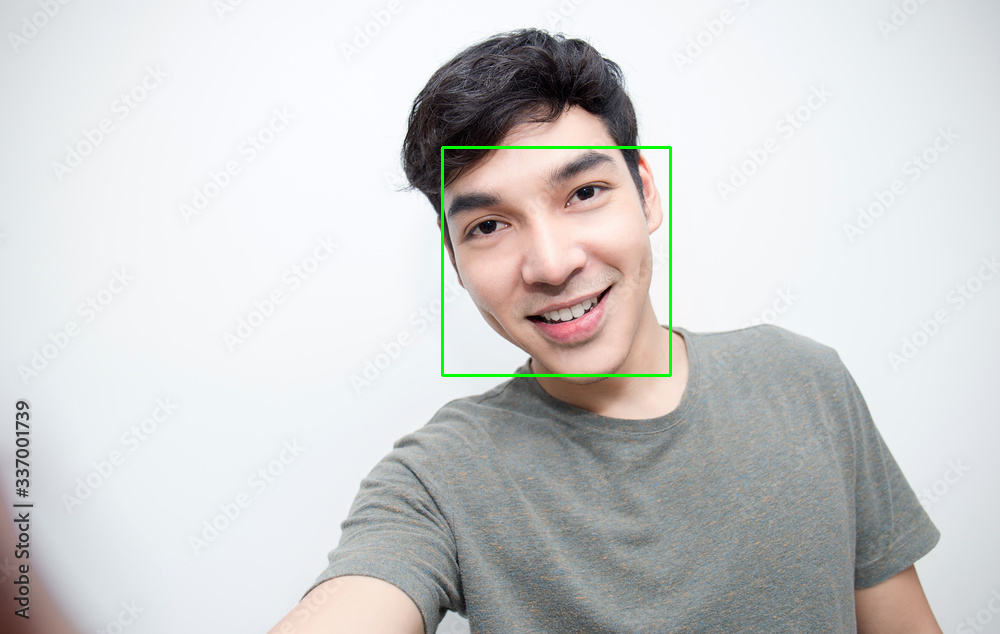

In [15]:
import cv2
import mediapipe as mp
from google.colab.patches import cv2_imshow
image=cv2.imread("/content/happy.jpg")

mp_face_detection = mp.solutions.face_detection
mp_drawing = mp.solutions.drawing_utils

with mp_face_detection.FaceDetection(min_detection_confidence=0.5) as face_detection:
  image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  # Detect faces in the image
  results = face_detection.process(image_rgb)

  if results.detections:
      for detection in results.detections:
          bboxC = detection.location_data.relative_bounding_box
          ih, iw, _ = image.shape
          x, y, w, h = int(bboxC.xmin * iw), int(bboxC.ymin * ih), int(bboxC.width * iw), int(bboxC.height * ih)

          # Draw bounding box and label
          cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)

  cv2_imshow(image)

In [2]:
!pip install spotipy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.3/250.3 kB 6.6 MB/s eta 0:00:00


In [79]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from collections import defaultdict

sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id="a04d200ec4f34289948bc2f912c97cf2", client_secret="9a17de9318a4477da09c5f231d5436fa"))
def recomend_artists(genres):
    dict={}
    recommendations = sp.recommendations(seed_genres=genres, limit=5)
    for i in range(len(recommendations['tracks'])):
      link=recommendations['tracks'][i]['album']['artists'][0]['external_urls']['spotify']
      artist=recommendations['tracks'][i]['album']['artists'][0]['name']
      dict[artist]=link
    return dict



In [80]:
recommendations=recomend_artists(['blues','reggae','metal'])


In [81]:
print(recommendations)

{'Various Artists': 'https://open.spotify.com/artist/0LyfQWJT6nXafLPZqxe9Of', 'Dexta Daps': 'https://open.spotify.com/artist/28UDeKu2FPrU0T7dpUiSGY', 'Protoje': 'https://open.spotify.com/artist/7BGR8y1VZAWK2oR4zD9COr', 'Stevie Ray Vaughan': 'https://open.spotify.com/artist/5fsDcuclIe8ZiBD5P787K1', 'Bob Marley & The Wailers': 'https://open.spotify.com/artist/2QsynagSdAqZj3U9HgDzjD'}


In [40]:
recomend_artists(['rock'])

{'AS IT IS': 'https://open.spotify.com/artist/3IXtskFMls8KXRipcIJT9y'}

In [54]:
recommendations[key:value]

NameError: ignored

In [77]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from collections import defaultdict

sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id="a04d200ec4f34289948bc2f912c97cf2",
                                                           client_secret="9a17de9318a4477da09c5f231d5436fa"))
def search_music(song_name):
  res=sp.search(song_name, limit=5, offset=0, type='track',market=None)
  return res['tracks']['items'][0]['external_urls']['spotify']

In [64]:
q='levitating'
res=sp.search(q, limit=5, offset=0, type='track',market=None)

In [78]:
print(search_music('shape of you'))

https://open.spotify.com/track/7qiZfU4dY1lWllzX7mPBI3
